# Music modification

In this notebook the raw mp3 files we have downloaded will be modified to a data form more suitable for machine learning.
The mp3 file format is a compression format. First we need to convert this to a more user friendly format called wave.

For this I have used ffmpeg, which can be downloaded [here.](https://ffmpeg.org/) For this notebook to work, you need to make sure that ffmpeg is added to your path environment.

# MP3 to WAV

In [5]:
import subprocess
import wave
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
def mp3_to_wav(f_in, f_out, mono=True):
    """
    :param f_in: (str) path including the extension.
    :param f_out: (str) path including the extension.
    :param mono: (bool) Convert from stereo to mono signal.
    :return: 
    """
    if mono:
        subprocess.call(["ffmpeg", "-i", f_in, "-ac", '1', f_out])
    else:
        subprocess.call(["ffmpeg", "-i", f_in, f_out])

In [2]:
# Root directory of your mp3 files.
root = "/media/ritchie46/5E061D60061D3A8B/dataset"

In [ ]:
# Convert all mp3 files to the .wav format.
for folder in os.listdir(os.path.join(root, "mp3")):
    print("converting {} music".format(folder))
    os.makedirs(os.path.join(root, "wav", folder), exist_ok=True)
    files = os.listdir(os.path.join(root, "mp3", folder))
    for file in files:
        if not os.path.isfile(os.path.join(root, "wav", folder, file.replace(".mp3", ".wav"))):
            f_in = os.path.join(root, "mp3", folder, file)
            f_out = os.path.join(root, "wav", folder, file.replace(".mp3", ".wav"))
            mp3_to_wav(f_in, f_out)

# Sound to images


In [ ]:
genres = ["metal", "rock", "hiphop", "edm_dance", "classical", "soul", "jazz", "reggae"]

# Mel Spectograms

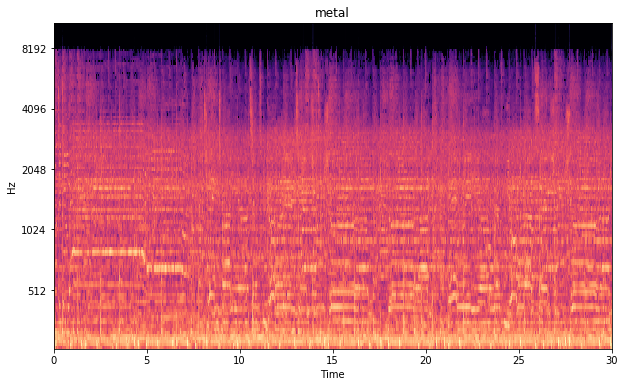

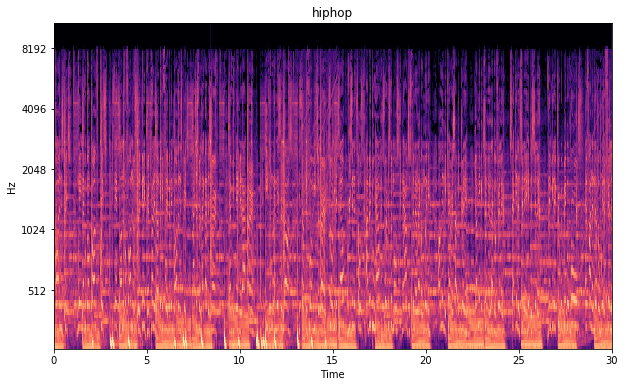

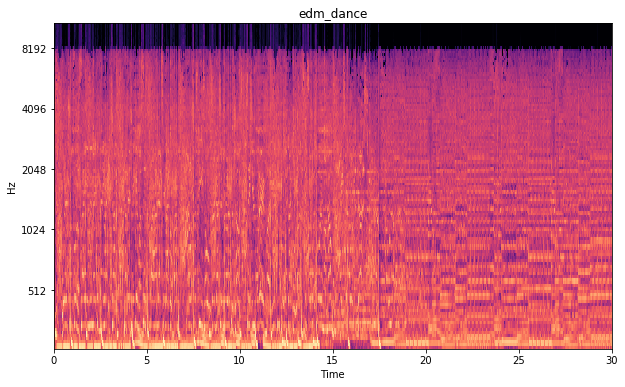

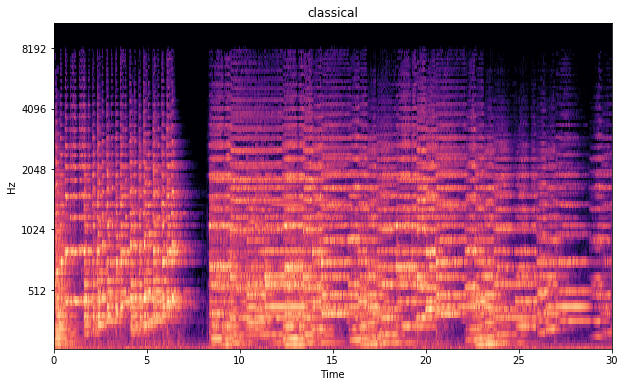

In [112]:
for i in range(len(genres)):
    genre_dir = os.path.join(wav_dir, genres[i])
    files = os.listdir(genre_dir)
    f = os.path.join(genre_dir, files[0])

    sr, ampl = scipy.io.wavfile.read(f)
    ms = librosa.power_to_db(librosa.feature.melspectrogram(ampl, sr), np.max)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(ms, sr=sr, x_axis="time", y_axis="mel")
    plt.title(genres[i])
    plt.show()
    plt.close()

# MFCC's

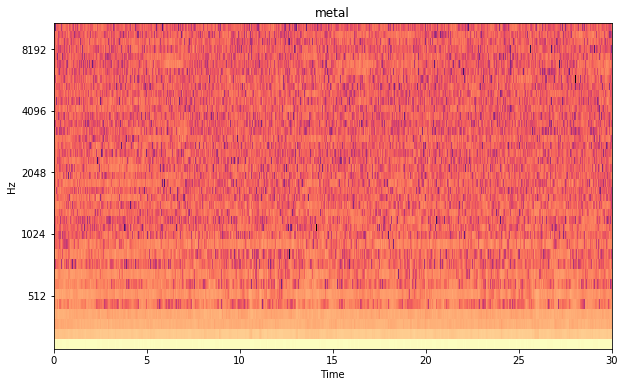

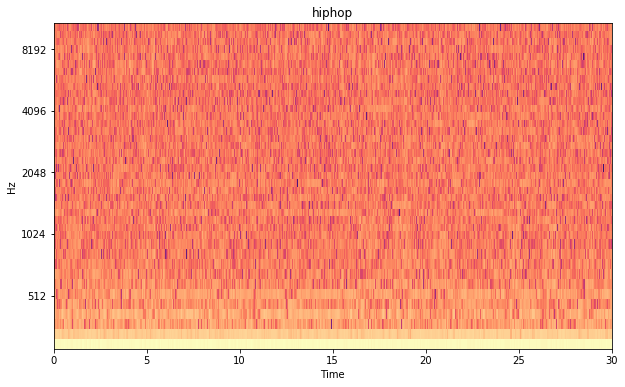

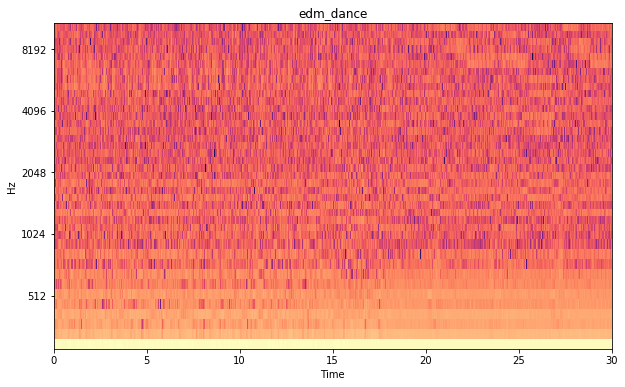

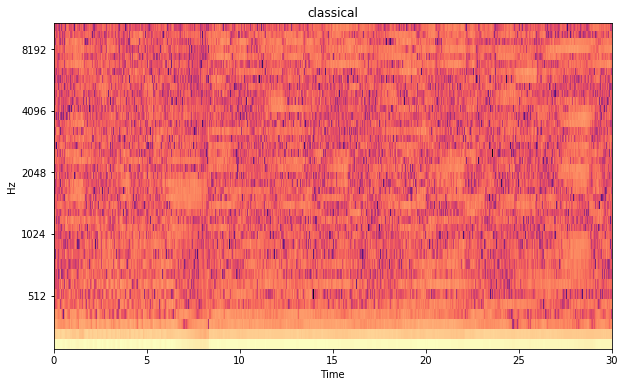

In [111]:
for i in range(len(genres)):
    genre_dir = os.path.join(wav_dir, genres[i])
    files = os.listdir(genre_dir)
    f = os.path.join(genre_dir, files[0])

    sr, ampl = scipy.io.wavfile.read(f)
    ms = librosa.power_to_db(librosa.feature.mfcc(ampl, sr, n_mfcc=40), np.max)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(ms, sr=sr, x_axis="time", y_axis="mel")
    plt.title(genres[i])
    plt.show()
    plt.close()

In [113]:
wav_dir = os.path.join(root, "wav")
for genre in os.listdir(wav_dir):
    print("{} has {} songs.".format(genre, len(os.listdir(os.path.join(wav_dir, genre)))))

classical has 2678 songs.
edm_dance has 2496 songs.
funk has 60 songs.
hiphop has 1212 songs.
jazz has 419 songs.
metal has 1588 songs.
reggae has 454 songs.
rock has 1150 songs.
soul has 746 songs.


# Data distribution

The code snippet above shos that the number of songs available per genre differs a lot. Because I want a somewhat equal data distribution I only continue with:

* metal
* hiphop
* edm_dance
* classical

In [3]:
genres = ["metal", "hiphop", "edm_dance", "classical"]

def save_spectograms(func, genres, dir_):
    """
    Save the spectograms as numpy arrays to the local disk.
    
    :param func: (function) Librosa function that extracts features from the audio signla
    :param genres: (list) Containing the genre strings.
    :dir_: (str) Save directory.
    """
    for i in range(len(genres)):
        print("Processing {} files".format(genres[i]))
        os.makedirs(os.path.join(root, dir_, genres[i]), exist_ok=True)
        genre_dir = os.path.join(wav_dir, genres[i])
        files = os.listdir(genre_dir)
        for j in range(len(files)):
            f = os.path.join(genre_dir, files[j])

            sr, ampl = scipy.io.wavfile.read(f)
            
            if func == librosa.feature.mfcc:
                ms = librosa.power_to_db(func(ampl, sr, n_mfcc=40), np.max)
            else:
                ms = librosa.power_to_db(func(ampl, sr), np.max)
            
            fn = os.path.join(root, dir_, genres[i], os.path.basename(f))
            if os.path.isfile(fn):
                print(os.path.basename(f), "already exists")
            else:
                np.save(fn, ms)
            if j % 50 == 0:
                print("Processed {} files".format(j + 1))



# MFCC dimension analysis

In [ ]:
save_spectograms(librosa.feature.mfcc, genres, "mfcc")

In [97]:
data = []
labels = []
for i in range(len(genres)):
    genre_dir = os.path.join(root, "mfcc", genres[i])
    files = os.listdir(genre_dir)
    for j in range(250):
        arr = np.load(os.path.join(genre_dir, files[j]))
        if arr.shape == (40,2584):
            data.append(arr)
            labels.append(i)
        else:
            print(arr.shape)

(40, 2954)
(40, 2590)
(40, 4731)
(40, 2838)
(40, 3002)
(40, 2606)
(40, 2621)


In [98]:
data = np.asarray(data)
labels = np.array(labels)
shape = data.shape
scl = StandardScaler()
data = scl.fit_transform(data.reshape((shape[0], shape[1] * shape[2])))

print(np.mean(data), np.std(data))

-2.02392550763e-16 1.0


In [99]:
length = data.shape[0]
shuffle_seed = np.arange(length, dtype="uint16")
np.random.shuffle(shuffle_seed)

In [100]:
data = data[shuffle_seed]
labels = labels[shuffle_seed]

In [104]:
model = TSNE()
sol = model.fit_transform(data)

In [12]:
color = np.array(["blue", "green", "pink", "red"], dtype="object")

plt.figure(figsize=(10, 6))
plt.scatter(sol[:,0], sol[:,1], c=color[labels])
plt.show()

In [109]:
pca = PCA(n_components=2)
sol_pca = pca.fit_transform(data)

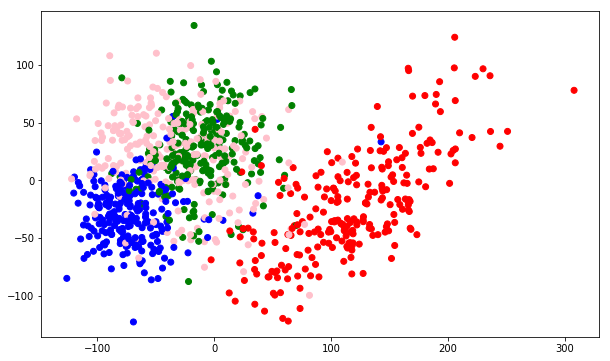

In [110]:
plt.figure(figsize=(10, 6))
plt.scatter(sol_pca[:,0], sol_pca[:,1], c=color[labels])
plt.show()

# Mel Spectogram dimension analysis

In [ ]:
save_spectograms(librosa.feature.melspectrogram, genres, "ms")

In [6]:
data = []
labels = []
for i in range(len(genres)):
    genre_dir = os.path.join(root, "ms", genres[i])
    files = os.listdir(genre_dir)
    for j in range(300):
        arr = np.load(os.path.join(genre_dir, files[j]))
        if arr.shape == (128,2584):
            data.append(arr)
            labels.append(i)
        else:
            print(arr.shape)

(128, 2954)
(128, 2590)
(128, 4731)
(128, 2838)
(128, 3002)
(128, 2606)
(128, 2621)


In [7]:
data = np.asarray(data)
labels = np.array(labels)
shape = data.shape
print(shape)
scl = StandardScaler()
data = scl.fit_transform(data.reshape((shape[0], shape[1] * shape[2])))

print(np.mean(data), np.std(data))

(1193, 128, 2584)
-1.35024491081e-15 1.0


In [8]:
length = data.shape[0]
shuffle_seed = np.arange(length, dtype="uint16")
np.random.shuffle(shuffle_seed)

In [9]:
data = data[shuffle_seed]
labels = labels[shuffle_seed]

In [10]:
model = TSNE()
sol = model.fit_transform(data)

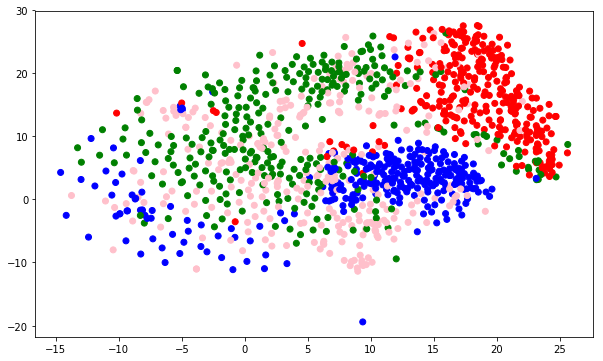

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(sol[:,0], sol[:,1], c=color[labels])
plt.show()

In [132]:
pca = PCA(n_components=2)
sol_pca = pca.fit_transform(data)

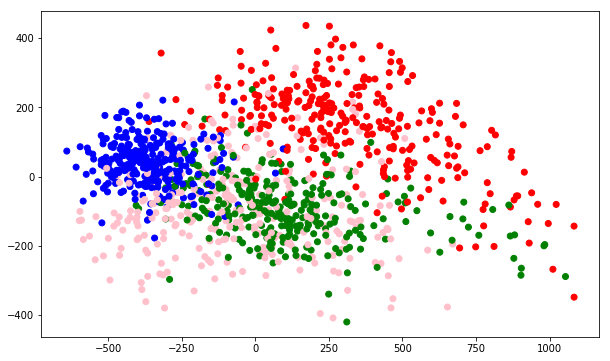

In [133]:
plt.figure(figsize=(10, 6))
plt.scatter(sol_pca[:,0], sol_pca[:,1], c=color[labels])
plt.show()